In [1]:
from  numpy import *
import cv2
import numpy
from scipy.cluster.vq import *
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import data
from skimage.metrics import (adapted_rand_error,
                              variation_of_information)
from skimage.filters import sobel
from skimage.measure import label
from skimage.util import img_as_float
from skimage.feature import canny
from skimage.morphology import remove_small_objects
from skimage.segmentation import (morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  watershed,
                                  mark_boundaries)
 
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import chan_vese

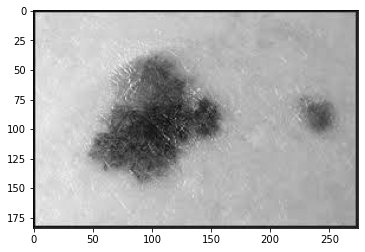

In [2]:
image = cv2.imread('../input/skin-cancer/cccc.jpg',0)
plt.imshow(image, cmap='gray')

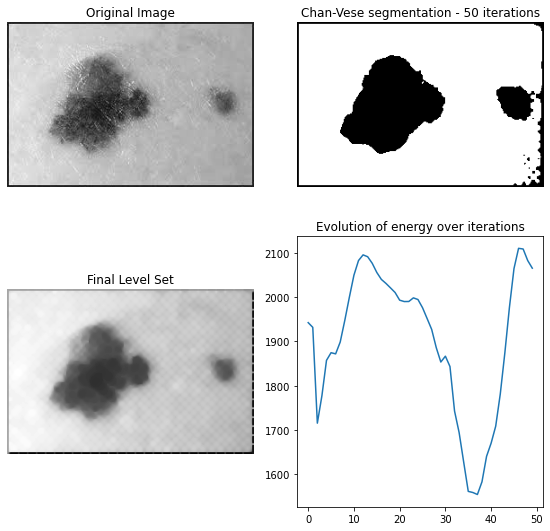

In [3]:


#image = img_as_float(data.camera())
# Feel free to play around with the parameters to see how they impact the result
cv = chan_vese(image, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=50,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

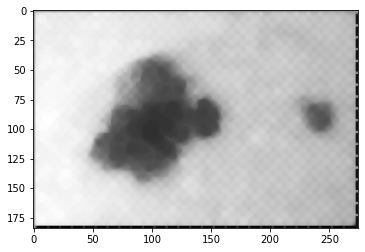

In [4]:
img_cv = cv[1]
plt.imshow(img_cv, cmap='gray')

For the segmented image using **chan vese****

In [5]:
elevation_map = sobel(img_cv)
markers = np.zeros_like(img_cv)
markers[img_cv < 30] = 1
markers[img_cv > 150] = 2
im_true = watershed(elevation_map, markers)
im_true = ndi.label(ndi.binary_fill_holes(im_true - 1))[0]

In [6]:
img_cv = img_as_float(img_cv)
gradient = inverse_gaussian_gradient(img_cv)
init_ls = np.zeros(img_cv.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
im_test3 = morphological_geodesic_active_contour(gradient, iterations= 200,
                                                 init_level_set=init_ls,
                                                 smoothing=1, balloon=-1,
                                                 threshold=0.69)
im_test3 = label(im_test3)

method_names = ['Morphological Geodesic Active Contours']
short_method_names = ['Compact WS', 'Canny', 'GAC']

precision_list = []
recall_list = []
split_list = []
merge_list = []
for name, im_test in zip(method_names, [im_test3]):
    error, precision, recall = adapted_rand_error(im_true, im_test)
    splits, merges = variation_of_information(im_true, im_test)
    split_list.append(splits)
    merge_list.append(merges)
    precision_list.append(precision)
    recall_list.append(recall)
    print(f"\n## Method: {name}")
    print(f"Adapted Rand error: {error}")
    print(f"Adapted Rand precision: {precision}")
    print(f"Adapted Rand recall: {recall}")
    print(f"False Splits: {splits}")
    print(f"False Merges: {merges}")



## Method: Morphological Geodesic Active Contours
Adapted Rand error: nan
Adapted Rand precision: nan
Adapted Rand recall: nan
False Splits: 0.6803334559237711
False Merges: 4.653198577675826e-19


/opt/conda/lib/python3.7/site-packages/skimage/metrics/_adapted_rand_error.py:70: RuntimeWarning: invalid value encountered in double_scalars
  precision = sum_p_ij2 / sum_a2
/opt/conda/lib/python3.7/site-packages/skimage/metrics/_adapted_rand_error.py:71: RuntimeWarning: invalid value encountered in double_scalars
  recall = sum_p_ij2 / sum_b2


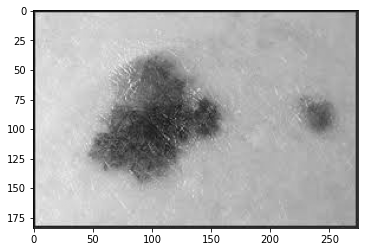

In [7]:
plt.imshow(mark_boundaries(image, im_true))

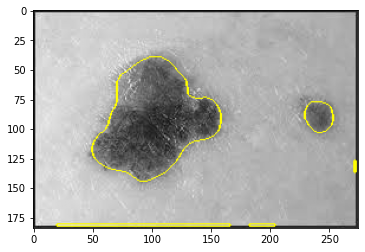

In [8]:
plt.imshow(mark_boundaries(image, im_test3))

For the original image ****

In [9]:
elevation_map = sobel(image)
markers = np.zeros_like(image)
markers[image < 30] = 1
markers[image > 150] = 2
im_true = watershed(elevation_map, markers)
im_true = ndi.label(ndi.binary_fill_holes(im_true - 1))[0]

In [10]:
edges = sobel(image)
im_test1 = watershed(edges, markers=468, compactness=0.001)

In [11]:
edges = canny(image)
fill_coins = ndi.binary_fill_holes(edges)
im_test2 = ndi.label(remove_small_objects(fill_coins, 21))[0]


## Method: Compact watershed
Adapted Rand error: 0.994098025082006
Adapted Rand precision: 0.0029597215602033097
Adapted Rand recall: 1.0
False Splits: 8.375179866788635
False Merges: 0.07974713166276613

## Method: Canny filter
Adapted Rand error: 0.0
Adapted Rand precision: 1.0
Adapted Rand recall: 1.0
False Splits: 0.012535430841139734
False Merges: 0.023808485666749313

## Method: Morphological Geodesic Active Contours
Adapted Rand error: 0.07847922342992641
Adapted Rand precision: 0.8544631704997783
Adapted Rand recall: 1.0
False Splits: 0.3843314091321482
False Merges: 0.10153730217942296


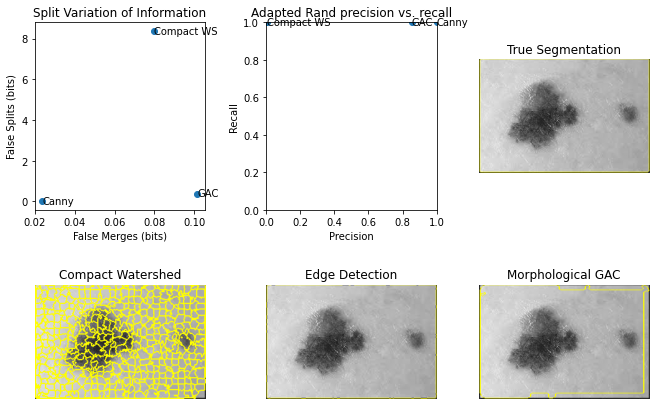

In [12]:
image = img_as_float(image)
gradient = inverse_gaussian_gradient(image)
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
im_test3 = morphological_geodesic_active_contour(gradient, iterations=200,
                                                 init_level_set=init_ls,
                                                 smoothing=1, balloon=-1,
                                                 threshold=0.69)
im_test3 = label(im_test3)

method_names = ['Compact watershed', 'Canny filter',
                'Morphological Geodesic Active Contours']
short_method_names = ['Compact WS', 'Canny', 'GAC']

precision_list = []
recall_list = []
split_list = []
merge_list = []
for name, im_test in zip(method_names, [im_test1, im_test2, im_test3]):
    error, precision, recall = adapted_rand_error(im_true, im_test)
    splits, merges = variation_of_information(im_true, im_test)
    split_list.append(splits)
    merge_list.append(merges)
    precision_list.append(precision)
    recall_list.append(recall)
    print(f"\n## Method: {name}")
    print(f"Adapted Rand error: {error}")
    print(f"Adapted Rand precision: {precision}")
    print(f"Adapted Rand recall: {recall}")
    print(f"False Splits: {splits}")
    print(f"False Merges: {merges}")

fig, axes = plt.subplots(2, 3, figsize=(9, 6), constrained_layout=True)
ax = axes.ravel()

ax[0].scatter(merge_list, split_list)
for i, txt in enumerate(short_method_names):
    ax[0].annotate(txt, (merge_list[i], split_list[i]),
                   verticalalignment='center')
ax[0].set_xlabel('False Merges (bits)')
ax[0].set_ylabel('False Splits (bits)')
ax[0].set_title('Split Variation of Information')

ax[1].scatter(precision_list, recall_list)
for i, txt in enumerate(short_method_names):
    ax[1].annotate(txt, (precision_list[i], recall_list[i]),
                   verticalalignment='center')
ax[1].set_xlabel('Precision')
ax[1].set_ylabel('Recall')
ax[1].set_title('Adapted Rand precision vs. recall')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

ax[2].imshow(mark_boundaries(image, im_true))
ax[2].set_title('True Segmentation')
ax[2].set_axis_off()

ax[3].imshow(mark_boundaries(image, im_test1))
ax[3].set_title('Compact Watershed')
ax[3].set_axis_off()

ax[4].imshow(mark_boundaries(image, im_test2))
ax[4].set_title('Edge Detection')
ax[4].set_axis_off()

ax[5].imshow(mark_boundaries(image, im_test3))
ax[5].set_title('Morphological GAC')
ax[5].set_axis_off()

plt.show()

TypeError: Input z must be 2D, not 3D

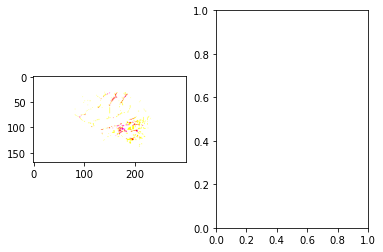

In [13]:
# ------------------------------------------------------------------------
# Region Based Active Contour Segmentation
#
# seg = region_seg(I, init_mask, max_its, alpha, display)
#
# Inputs: I           2D image
#         init_mask   Initialization (1 = foreground, 0 = bg)
#         max_its     Number of iterations to run segmentation for
#         alpha       (optional) Weight of smoothing term
#                       higer = smoother.  default = 0.2
#         display     (optional) displays intermediate outputs
#                       default = true
#
# Outputs: seg        Final segmentation mask (1=fg, 0=bg)
#
# Description: This code implements the paper: "Active Contours Without
# Edges" By Chan Vese. This is a nice way to segment images whose
# foregrounds and backgrounds are statistically different and homogeneous.
#
# Example:
# img = imread('tire.tif');
# m = zeros(size(img));
# m(33:33+117, 44:44+128) = 1;
# seg = region_seg(img, m, 500);
#
# Coded by: Shawn Lankton (www.shawnlankton.com)
# ------------------------------------------------------------------------
# 
# Gif montage (save each step in a gif folder):
# convert -delay 50 gif/levelset*.png levelset.gif

import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt


eps = np.finfo(float).eps


def chanvese(I, init_mask, max_its=200, alpha=0.2,
             thresh=0, color='r', display=False):
    I = I.astype(np.float)

    # Create a signed distance map (SDF) from mask
    phi = mask2phi(init_mask)

    if display:
        plt.ion()
        fig, axes = plt.subplots(ncols=2)
        show_curve_and_phi(fig, I, phi, color)
        plt.savefig('levelset_start.png', bbox_inches='tight')

    # Main loop
    its = 0
    stop = False
    prev_mask = init_mask
    c = 0

    while (its < max_its and not stop):
        # Get the curve's narrow band
        idx = np.flatnonzero(np.logical_and(phi <= 1.2, phi >= -1.2))

        if len(idx) > 0:
            # Intermediate output
            if display:
                if np.mod(its, 50) == 0:
                    print('iteration: {0}'.format(its))
                    show_curve_and_phi(fig, I, phi, color)
            else:
                if np.mod(its, 10) == 0:
                    print('iteration: {0}'.format(its))

            # Find interior and exterior mean
            upts = np.flatnonzero(phi <= 0)  # interior points
            vpts = np.flatnonzero(phi > 0)  # exterior points
            u = np.sum(I.flat[upts]) / (len(upts) + eps)  # interior mean
            v = np.sum(I.flat[vpts]) / (len(vpts) + eps)  # exterior mean

            # Force from image information
            F = (I.flat[idx] - u)**2 - (I.flat[idx] - v)**2
            # Force from curvature penalty
            curvature = get_curvature(phi, idx)

            # Gradient descent to minimize energy
            dphidt = F / np.max(np.abs(F)) + alpha * curvature

            # Maintain the CFL condition
            dt = 0.45 / (np.max(np.abs(dphidt)) + eps)

            # Evolve the curve
            phi.flat[idx] += dt * dphidt

            # Keep SDF smooth
            phi = sussman(phi, 0.5)

            new_mask = phi <= 0
            c = convergence(prev_mask, new_mask, thresh, c)

            if c <= 5:
                its = its + 1
                prev_mask = new_mask
            else:
                stop = True

        else:
            break

    # Final output
    if display:
        show_curve_and_phi(fig, I, phi, color)
        plt.savefig('levelset_end.png', bbox_inches='tight')

    # Make mask from SDF
    seg = phi <= 0  # Get mask from levelset

    return seg, phi, its


# ---------------------------------------------------------------------
# ---------------------- AUXILIARY FUNCTIONS --------------------------
# ---------------------------------------------------------------------

def bwdist(a):
    """
    Intermediary function. 'a' has only True/False vals,
    so we convert them into 0/1 values - in reverse.
    True is 0, False is 1, distance_transform_edt wants it that way.
    """
    return nd.distance_transform_edt(a == 0)


# Displays the image with curve superimposed
def show_curve_and_phi(fig, I, phi, color):
    fig.axes[0].cla()
    fig.axes[0].imshow(I, cmap='gray')
    fig.axes[0].contour(phi, 0, colors=color)
    fig.axes[0].set_axis_off()
    plt.draw()

    fig.axes[1].cla()
    fig.axes[1].imshow(phi)
    fig.axes[1].set_axis_off()
    plt.draw()
    
    plt.pause(0.001)


def im2double(a):
    a = a.astype(np.float)
    a /= np.abs(a).max()
    return a


# Converts a mask to a SDF
def mask2phi(init_a):
    phi = bwdist(init_a) - bwdist(1 - init_a) + im2double(init_a) - 0.5
    return phi


# Compute curvature along SDF
def get_curvature(phi, idx):
    dimy, dimx = phi.shape
    yx = np.array([np.unravel_index(i, phi.shape) for i in idx])  # subscripts
    y = yx[:, 0]
    x = yx[:, 1]

    # Get subscripts of neighbors
    ym1 = y - 1
    xm1 = x - 1
    yp1 = y + 1
    xp1 = x + 1

    # Bounds checking
    ym1[ym1 < 0] = 0
    xm1[xm1 < 0] = 0
    yp1[yp1 >= dimy] = dimy - 1
    xp1[xp1 >= dimx] = dimx - 1

    # Get indexes for 8 neighbors
    idup = np.ravel_multi_index((yp1, x), phi.shape)
    iddn = np.ravel_multi_index((ym1, x), phi.shape)
    idlt = np.ravel_multi_index((y, xm1), phi.shape)
    idrt = np.ravel_multi_index((y, xp1), phi.shape)
    idul = np.ravel_multi_index((yp1, xm1), phi.shape)
    idur = np.ravel_multi_index((yp1, xp1), phi.shape)
    iddl = np.ravel_multi_index((ym1, xm1), phi.shape)
    iddr = np.ravel_multi_index((ym1, xp1), phi.shape)

    # Get central derivatives of SDF at x,y
    phi_x = -phi.flat[idlt] + phi.flat[idrt]
    phi_y = -phi.flat[iddn] + phi.flat[idup]
    phi_xx = phi.flat[idlt] - 2 * phi.flat[idx] + phi.flat[idrt]
    phi_yy = phi.flat[iddn] - 2 * phi.flat[idx] + phi.flat[idup]
    phi_xy = 0.25 * (- phi.flat[iddl] - phi.flat[idur] +
                     phi.flat[iddr] + phi.flat[idul])
    phi_x2 = phi_x**2
    phi_y2 = phi_y**2

    # Compute curvature (Kappa)
    curvature = ((phi_x2 * phi_yy + phi_y2 * phi_xx - 2 * phi_x * phi_y * phi_xy) /
                 (phi_x2 + phi_y2 + eps) ** 1.5) * (phi_x2 + phi_y2) ** 0.5

    return curvature


# Level set re-initialization by the sussman method
def sussman(D, dt):
    # forward/backward differences
    a = D - np.roll(D, 1, axis=1)
    b = np.roll(D, -1, axis=1) - D
    c = D - np.roll(D, -1, axis=0)
    d = np.roll(D, 1, axis=0) - D

    a_p = np.clip(a, 0, np.inf)
    a_n = np.clip(a, -np.inf, 0)
    b_p = np.clip(b, 0, np.inf)
    b_n = np.clip(b, -np.inf, 0)
    c_p = np.clip(c, 0, np.inf)
    c_n = np.clip(c, -np.inf, 0)
    d_p = np.clip(d, 0, np.inf)
    d_n = np.clip(d, -np.inf, 0)

    a_p[a < 0] = 0
    a_n[a > 0] = 0
    b_p[b < 0] = 0
    b_n[b > 0] = 0
    c_p[c < 0] = 0
    c_n[c > 0] = 0
    d_p[d < 0] = 0
    d_n[d > 0] = 0

    dD = np.zeros_like(D)
    D_neg_ind = np.flatnonzero(D < 0)
    D_pos_ind = np.flatnonzero(D > 0)

    dD.flat[D_pos_ind] = np.sqrt(
        np.max(np.concatenate(
            ([a_p.flat[D_pos_ind]**2], [b_n.flat[D_pos_ind]**2])), axis=0) +
        np.max(np.concatenate(
            ([c_p.flat[D_pos_ind]**2], [d_n.flat[D_pos_ind]**2])), axis=0)) - 1
    dD.flat[D_neg_ind] = np.sqrt(
        np.max(np.concatenate(
            ([a_n.flat[D_neg_ind]**2], [b_p.flat[D_neg_ind]**2])), axis=0) +
        np.max(np.concatenate(
            ([c_n.flat[D_neg_ind]**2], [d_p.flat[D_neg_ind]**2])), axis=0)) - 1

    D = D - dt * sussman_sign(D) * dD
    return D


def sussman_sign(D):
    return D / np.sqrt(D**2 + 1)


# Convergence Test
def convergence(p_mask, n_mask, thresh, c):
    diff = p_mask - n_mask
    n_diff = np.sum(np.abs(diff))
    if n_diff < thresh:
        c = c + 1
    else:
        c = 0
    return c

import matplotlib.pyplot
import imageio

if __name__ == "__main__":
    img = imageio.imread('../input/3d-brain-image/3D brain image.jpg')
    
    type(img)
    img.shape[0] * img.shape[1], img.shape[2]
    mask = np.zeros(img.shape)
    mask[20:100, 20:100] = 1

    chanvese(img, mask, max_its=1000, display=True, alpha=1.0)

In [14]:
Img = plt.imread("../input/3d-brain-image/3D brain image.jpg")
Img.shape

(168, 300, 3)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import scipy.ndimage as image
import time
from scipy import ndimage

def bwdist(a):
    
    """
   this is an intermediary function, 'a' has only True, False vals,
   so we convert them into 0, 1 values -- in reverse. True is 0,
   False is 1, distance_transform_edt wants it that way.
   """
    b = np.ones(a.shape)
    b[a==True] = 0.
    return ndimage.distance_transform_edt(b)

def gauss_kern():
    """ Returns a normalized 2D gauss kernel array for convolutions """
    h1 = 15
    h2 = 15
    x, y = np.mgrid[0:h2, 0:h1]
    x = x-h2/2
    y = y-h1/2
    sigma = 1.5
    g = np.exp( -( x**2 + y**2 ) / (2*sigma**2) );
    return g / g.sum()

Img = plt.imread("../input/brain-image/brain.png")
Img = Img[::-1]
g = gauss_kern()
Img_smooth = signal.convolve(Img,g,mode='same')
Iy,Ix=np.gradient(Img_smooth)
absGradI=np.sqrt(Ix**2+Iy**2);
rows, cols = Img.shape

# initial function phi - level set is a square 4 pixels
# away from borders on each side, in 3D it looks like an empty
# box
c0=4
w=4
nrow, ncol=Img.shape
phi=c0*np.ones((nrow,ncol))
phi[w+1:-w-1, w+1:-w-1]=-c0

# edge-stopping function
g = 1 / (1+absGradI**2)

# gradient of edge-stopping function
gy,gx = np.gradient(g)

# gradient descent step size
dt=.4

# number of iterations after which we reinitialize the surface
num_reinit=10

phiOld=np.zeros((rows,cols))

# number of iterations after which we reinitialize the surface
iter=0

plt.ion()

while np.sum(np.sum(np.abs(phi-phiOld))) != 0:
    # gradient of phi
    gradPhiY, gradPhiX = np.gradient(phi)   
    # magnitude of gradient of phi
    absGradPhi=np.sqrt(gradPhiX**2+gradPhiY**2)
    # normalized gradient of phi - eliminating singularities
    normGradPhiX=gradPhiX/(absGradPhi+(absGradPhi==0))
    normGradPhiY=gradPhiY/(absGradPhi+(absGradPhi==0))
    

  
    divYnormGradPhiX, divXnormGradPhiX=np.gradient(normGradPhiX)
    divYnormGradPhiY, divXnormGradPhiY=np.gradient(normGradPhiY)
                         
   # curvature is the divergence of normalized gradient of phi
    K = divXnormGradPhiX + divYnormGradPhiY   
    tmp1 = g * K * absGradPhi
    tmp2 = g * absGradPhi
    tmp3 = gx * gradPhiX + gy*gradPhiY
    dPhiBydT =tmp1 + tmp2 + tmp3
    phiOld=phi
   # level set evolution equation   
    phi = phi + ( dt * dPhiBydT )
    iter=iter+1
    if np.mod(iter,num_reinit)==0:
        phi=np.sign(phi)
        phi = (phi > 0) * (bwdist(phi != 0))
        #reinitialize the embedding function after num_reinit iterations

      
    if np.mod(iter,10)==0:
        time.sleep(0.6)
        plt.imshow(Img, cmap='gray')
        plt.hold(True)
        CS = plt.contour(phi,0, colors='r')
        plt.draw()
        plt.hold(False)

ValueError: volume and kernel should have the same dimensionality